# Image files for animation of COWVR EDR wind speed data during first year of operation

This notebook demonstrates plotting daily images of COWVR EDR wind speed - each image includes all satellite passes for that day. The COWVR data are accessed using the `earthaccess()` package (data are "streamed" via `xarray`), and the notebook is written such that it will work both on a local machine or in the cloud. That being said, at the time this notebook was written, streaming COWVR data from a local machine via `xarray` was much slower than direct cloud access.

#### Additional required files
The following image files need to be in the same directory as this notebook:
```
bluemarble.png
nasa_jpl_logo_0.png
podaac_logo_B_color.png
```

#### Optional parallel computation section
If the user wishes to generate images for the entire year, this involves processing ~8,500 files at ~1 TB total. This can be run in serial, but would take a projected 9 - 12 hours (at least at the time this notebook was written). Therefore, there is an optional parallel computing section, which will process the files on a local cluster. We used an AWS EC2 instance type `m6i.4xlarge`, which has 16 vCPUs.

In [39]:
# Built in packages
import os
import gc
import pathlib
import datetime

# Packages for math and scientific computing
import earthaccess
import numpy as np
import xarray as xr

# Plotting packages
import cartopy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.image as mpimg

%matplotlib inline

In [ ]:
# Optional: parallel computing packages
from dask.distributed import Client
from dask import delayed
import dask.array as da

### Define data analysis / plotting function

In [40]:
# Generates image for 1 day of data:
def plot_1day(date, outputdir="./", ancillary_images=None):

    img_podaac = ancillary_images['img_podaac']
    img_nasa = ancillary_images['img_nasa']
    img_bluemarble = ancillary_images['img_bluemarble']
    
    
    # File-like objects for all files within the date range:
    earthaccess.login()
    gran_info = earthaccess.search_data(
        short_name = "COWVR_STPH8_L2_EDR_V9.0", 
        cloud_hosted = True,
        temporal=(date+"T00:00:00", date+"T23:59:59"),
        )
    if len(gran_info)==0:
        return # skip this date if no granules available
    fileobjs = earthaccess.open(gran_info)
    #return fileobjs    # for testing coiled errors
    

    # Setup plotting axes with blue-marble background:
    plt.style.use('dark_background')
    fig=plt.figure(figsize=(16, 9), dpi=150)
    ax1 = plt.axes([0., 0.15, 0.999, 0.725], projection=cartopy.crs.PlateCarree())
    ax1.set_global()
    img_extent = (-180, 180, -90, 90)
    ax1.imshow(img_bluemarble, origin='upper', extent=img_extent, transform=cartopy.crs.PlateCarree(), zorder=-10)

    
    # Plot all orbits for the day:
    cmap_new = truncate_colormap(plt.get_cmap('cubehelix'), minval=0.075, maxval=0.75) # Adjust bounds on colormap slightly, see function below.
    for f in fileobjs[:]:
        envvars = xr.open_dataset(f, group='EnvDataRecords', phony_dims='access') # phony_dims kwarg needed for S3 access of this data set.
        geoloc = xr.open_dataset(f, group='GriddedGeolocationAndFlags', phony_dims='access')

        wspd_qc = envvars['wind_speed'].where((envvars['wind_speed_flag']==0)) # Apply QC flag
        pcm = ax1.pcolormesh(
            geoloc['grid_lon'], geoloc['grid_lat'], wspd_qc, 
            cmap=cmap_new, vmin=0, vmax=20, transform=cartopy.crs.PlateCarree()
            )
        
        del envvars, geoloc, wspd_qc
        gc.collect()


    # Add title, labels, colobar:
    fig.text(
        0.5, 0.98, "Wind Speed from COWVR EDR Level 2 Product, First Year of Operation", 
        ha='center', va='top', fontsize=20, fontweight='bold'
        )
    ax1.set_title(date, fontsize=18, fontweight='bold')
    position=fig.add_axes([0.34,0.07,0.33,0.02])  ## the parameters are the specified position you set
    cb = fig.colorbar(pcm, cax=position, orientation='horizontal', extend='max')
    cb.ax.set_title("wind speed (m/s)", fontsize=18, fontweight='bold')
    cb.ax.tick_params(axis='x', which='major', labelsize=14)


    # Add logos:
        # NASA:
    ax2 = plt.axes([0.85, 0.01, 0.1, 0.1])
    ax2.set_yticklabels([])
    ax2.set_xticklabels([])
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    ax2.set_axis_off()
    ax2.imshow(img_nasa)
        # PO.DAAC:
    ax3 = plt.axes([0.91, 0.01, 0.1, 0.1])
    ax3.set_yticklabels([])
    ax3.set_xticklabels([])
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)
    ax3.set_axis_off()
    ax3.imshow(img_podaac)

    # method 1:
    fig.savefig(outputdir + "COWVR_STPH8_L2_EDR_V9.0_" + date + ".jpg")
    plt.close(fig)
    del fig, ax1, ax2, ax3, img_podaac, img_nasa, img_bluemarble
    gc.collect()

    # method 2:
    #plt.close(fig)
    #return fig

    # method 3:
    #fname_img = outputdir + "COWVR_STPH8_L2_EDR_V9.0_" + date + ".jpg"
    #fig.savefig(fname_img)
    #plt.close(fig)
    #del fig
    #image = open(fname_img, 'rb').read()
    #pathlib.Path.unlink(fname_img)
    #return image


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

### Some prep work before running the function

In [41]:
earthaccess.login()

In [42]:
# Generate list of strings for all dates to create images for (year 2022):
d1 = datetime.date(2022, 1, 8)
d2 = datetime.date(2022, 12, 31)
dates_2022 = [d1 + datetime.timedelta(days=x) for x in range((d2-d1).days + 1)]
dates_2022 = [d.strftime('%Y%m%d') for d in dates_2022]
dates_2022 = [d[0:4]+"-"+d[4:6]+"-"+d[6:8] for d in dates_2022]

print(len(dates_2022))
print(dates_2022[:10])

358
['2022-01-08', '2022-01-09', '2022-01-10', '2022-01-11', '2022-01-12', '2022-01-13', '2022-01-14', '2022-01-15', '2022-01-16', '2022-01-17']


In [43]:
# Load some ancillary images to include in the figures, includeing a background blue-marble 
# image behind the data, and NASA/PO.DAAC logos in the corner. This code assumes the files
# are in the same folder as this notebook: 
img_podaac = plt.imread('podaac_logo_B_color.png')
img_nasa = plt.imread('nasa_jpl_logo_0.png')
img_bluemarble = plt.imread('bluemarble.png')

ancillary_images = {'img_podaac':img_podaac, 'img_nasa':img_nasa, 'img_bluemarble':img_bluemarble}

### Test the function to create image for a single day

In [47]:
# Create directory to save images in:
!mkdir animation_images

In [48]:
%%time

# Image file will be saved to the above directory:
_ = plot_1day(dates_2022[0], outputdir="./animation_images/", ancillary_images=ancillary_images)

Granules found: 22
Opening 22 granules, approx size: 2.46 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/22 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/22 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/22 [00:00<?, ?it/s]

CPU times: user 44.6 s, sys: 6.01 s, total: 50.7 s
Wall time: 1min 30s


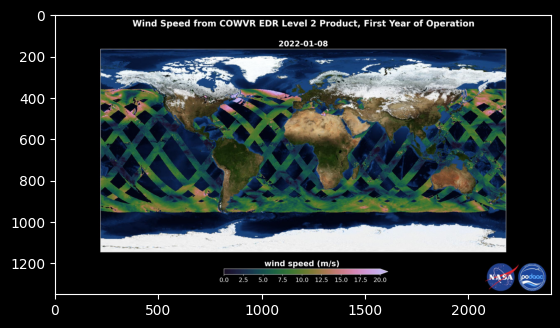

In [49]:
# Show the image (note that in the actual saved image, the axis tick labels do not appear:
img = mpimg.imread("./animation_images/COWVR_STPH8_L2_EDR_V9.0_" + dates_2022[0] + ".jpg")
imgplot = plt.imshow(img)
plt.show()

### Optional: Parallelize image generation using dask and a local cluster

We used an AWS EC2 instance type `m6i.4xlarge`, which has 16 vCPUs. And since there is enough memory per CPU on this instance for our computations, we used 16 workers.

First, it is necessary to write a quick authentication function which will be run on each worker, ensuring that they have the same EDL credentials (and therefore NASA Earthdata access), as this notebook (recall we established ours with a call to `earthdata.login()` earlier).

In [ ]:
def auth_env(auth):
    os.environ["EARTHDATA_USERNAME"] = auth["EARTHDATA_USERNAME"]
    os.environ["EARTHDATA_PASSWORD"] = auth["EARTHDATA_PASSWORD"]

Now, a quick detour. Ideally the following code would work. This code starts up a single local cluster with 16 workers, then asks the workers churn through the 358 days. 

```
client = Client(n_workers=16, threads_per_worker=1)
client.run(auth_env, auth=earthaccess.auth_environ()) # Get EDL creds on each worker

# Process all granules in parallel using Dask
plot_1day_delayed = delayed(plot_1day)
tasks = [
    plot_1day_delayed(d, outputdir="./animation_images/", ancillary_images=ancillary_images) 
    for d in dates_2022[:] 
    ]
results = da.compute(*tasks)

client.close()
```


However, due to very low level workings of Python (and even lower level languages?), our workers tend not to release all of the memory they used to process one of the days, meaning that as they churn through more and more days, less memory is available until the code crashes. Therefore, we use the following (admittedly very not glamorous) workaround in the next section.

### Work around for Dask workers accumulating too much memory
Instead, we work in batches of 16 files, calling and closing a sepearte local cluster for each batch. This apparently releases the memory fully once the cluster is closed. ***Note that the output for the last block of code is very long, and may be full of warning messages, but for us still completed successfully.***

In [50]:
# Index numbers for the batches (used to slice the dates_2022 list):
i_list = []
i_list.append(0)
for x in range(1, int(np.floor(len(dates_2022)/16))):
    i_list.append(i_list[-1] + 16)
i_list.append(len(dates_2022))
print(i_list[:5])

[0, 16, 32, 48, 64]


In [34]:
results = []

plot_1day_delayed = delayed(plot_1day)

for i in range(1, len(i_list)):

    # Starts cluster:
    client = Client(n_workers=16, threads_per_worker=1)
    client.run(auth_env, auth=earthaccess.auth_environ())

    # Runs batch of tasks:
    tasks_i = [
        plot_1day_delayed(d, outputdir="./animation_images/", ancillary_images=ancillary_images) 
        for d in dates_2022[i_list[i-1] : i_list[i]] 
        ]
    results_i = da.compute(*tasks_i)

    # Closes cluster:
    client.close()

    results.append(results_i)

/opt/coiled/env/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37017 instead
  warnings.warn(
/opt/coiled/env/lib/python3.11/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 126.46 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Granules found: 22
Granules found: 26
Granules found: 12
Granules found: 26
Granules found: 26
Granules found: 24
Granules found: 25
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 18
Granules found: 26
Granules found: 26
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Granules found: 26
Opening 22 granules, approx size: 2.46 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 25 granules, approx size: 2.84 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.97 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 18 g

QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1695.85it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 102.04it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 396552.38it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1957.63it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1061.95it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1030.55it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 106.09it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 359907.27it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 110.06it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 276080.77it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 114.63it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 364722.09it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1830.93it/s]
QUEUEING TASKS | : 100%|██████████| 12/12 [00:00<00:00, 460.91it/s]
QUEUEIN

Granules found: 26
Granules found: 25
Granules found: 26
Granules found: 26
Granules found: 21
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 24
Granules found: 26
Granules found: 26
Granules found: 24
Granules found: 26
Granules found: 18
Granules found: 26
Granules found: 26
Opening 26 granules, approx size: 2.99 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.99 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 24 granules, approx size: 2.75 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.99 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.99 GBOpening 26 granules, approx size: 2.99 GB
using endpoint: https://archive.podaac.eart

QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1066.98it/s]
QUEUEING TASKS | : 100%|██████████| 18/18 [00:00<00:00, 811.28it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1826.54it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 103.39it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 385342.42it/s]
PROCESSING TASKS | : 100%|██████████| 18/18 [00:00<00:00, 80.01it/s]
COLLECTING RESULTS | : 100%|██████████| 18/18 [00:00<00:00, 238162.37it/s]
QUEUEING TASKS | : 100%|██████████| 24/24 [00:00<00:00, 1008.14it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 996.41it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 105.60it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 393689.18it/s]
QUEUEING TASKS | : 100%|██████████| 25/25 [00:00<00:00, 906.70it/s]
QUEUEING TASKS | : 100%|██████████| 21/21 [00:00<00:00, 792.67it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 965.61it/s]
PROCESSING TASKS | 

Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 25
Granules found: 26
Granules found: 26
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.99 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.99 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.99 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 g

QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1215.05it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1236.77it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 991.25it/s]
QUEUEING TASKS | : 100%|██████████| 25/25 [00:00<00:00, 1746.26it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 908.23it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 113.99it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 376041.05it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 854.67it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 107.63it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 293940.44it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 114.47it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 297144.15it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 113.46it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 344012.32it/s]
PROCESSIN

Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 25
Granules found: 24
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 25
Granules found: 26
Granules found: 25
Granules found: 26
Granules found: 21
Granules found: 26
Granules found: 26
Opening 26 granules, approx size: 2.91 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.99 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 25 granules, approx size: 2.87 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 25 granules, approx size: 2.87 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 25 g

QUEUEING TASKS | : 100%|██████████| 25/25 [00:00<00:00, 1891.37it/s]
PROCESSING TASKS | :   4%|▍         | 1/25 [00:00<00:04,  5.16it/s]]
QUEUEING TASKS | : 100%|██████████| 21/21 [00:00<00:00, 841.52it/s]
PROCESSING TASKS | : 100%|██████████| 25/25 [00:00<00:00, 102.55it/s]
COLLECTING RESULTS | : 100%|██████████| 25/25 [00:00<00:00, 404855.60it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1563.04it/s]
QUEUEING TASKS | : 100%|██████████| 24/24 [00:00<00:00, 1677.05it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 982.39it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1113.62it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1690.28it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1269.82it/s]
QUEUEING TASKS | : 100%|██████████| 25/25 [00:00<00:00, 795.20it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1168.44it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 109.20it/s]
COLLECTING RESULTS | : 100%|█

Granules found: 26
Granules found: 9
Granules found: 26
Granules found: 26
Granules found: 5
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 24
Granules found: 26
Granules found: 25
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 25
Opening 9 granules, approx size: 0.92 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.87 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.97 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 25 granules, approx size: 2.86 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.97 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 gran

QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1058.12it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1022.07it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 105.85it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 354064.62it/s]
QUEUEING TASKS | : 100%|██████████| 9/9 [00:00<00:00, 409.36it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 108.88it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 363506.35it/s]
QUEUEING TASKS | : 100%|██████████| 24/24 [00:00<00:00, 2213.65it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 923.75it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 781.10it/s]
PROCESSING TASKS | : 100%|██████████| 9/9 [00:00<00:00, 44.29it/s]
COLLECTING RESULTS | : 100%|██████████| 9/9 [00:00<00:00, 200791.15it/s]
PROCESSING TASKS | : 100%|██████████| 24/24 [00:00<00:00, 93.11it/s]
COLLECTING RESULTS | : 100%|██████████| 24/24 [00:00<00:00, 302292.18it/s]
PROCESSING TASKS 

Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 25
Granules found: 26
Granules found: 9
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Opening 25 granules, approx size: 2.86 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 9 granules, approx size: 1.03 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.97 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.96 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.96 GB
using endpoint: https://archive.podaac.earthdata

QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1839.42it/s]
QUEUEING TASKS | : 100%|██████████| 9/9 [00:00<00:00, 350.66it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1006.93it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 999.00it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1446.50it/s]
PROCESSING TASKS | : 100%|██████████| 9/9 [00:00<00:00, 43.42it/s]
COLLECTING RESULTS | : 100%|██████████| 9/9 [00:00<00:00, 154076.47it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 100.77it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 373465.42it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1138.67it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1691.17it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 109.84it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 382638.26it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 111.98it/s]
COLLECTING RESULTS | 

Granules found: 26
Granules found: 12
Granules found: 26
Granules found: 25
Granules found: 26
Granules found: 26
Granules found: 25
Granules found: 26
Granules found: 26
Granules found: 6
Granules found: 4
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.97 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.97 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 25 granules, approx size: 2.86 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 25 granules, approx size: 2.86 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 12 granules, approx size: 1.37 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 gra

QUEUEING TASKS | : 100%|██████████| 4/4 [00:00<00:00, 435.15it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1009.81it/s]
QUEUEING TASKS | : 100%|██████████| 6/6 [00:00<00:00, 535.56it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 968.76it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 977.89it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1069.36it/s]
QUEUEING TASKS | :   0%|          | 0/26 [00:00<?, ?it/s]293.63it/s]
QUEUEING TASKS | : 100%|██████████| 25/25 [00:00<00:00, 1638.76it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 866.74it/s]
PROCESSING TASKS | : 100%|██████████| 4/4 [00:00<00:00, 21.19it/s]
COLLECTING RESULTS | : 100%|██████████| 4/4 [00:00<00:00, 78398.21it/s]
QUEUEING TASKS | : 100%|██████████| 25/25 [00:00<00:00, 880.49it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 100.90it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 281787.87it/s]
PROCESSING TASKS | : 100%|██████████

Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 25
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 24
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 25
Opening 26 granules, approx size: 2.73 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Granules found: 25
Opening 26 granules, approx size: 2.97 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.97 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.97 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 g

QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1778.73it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1027.32it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1046.30it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1022.77it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1053.51it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 2485.46it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 105.92it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 290031.66it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 106.72it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 295533.62it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 857.99it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 107.53it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 278193.63it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1719.06it/s]
PROCESSING TAS

Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 25
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Granules found: 26
Opening 26 granules, approx size: 2.97 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.97 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.97 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 g

QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1204.57it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1001.13it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 968.39it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1913.22it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1022.93it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 985.22it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 953.33it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 82.22it/s] 
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 323596.15it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 75.84it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 290031.66it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 73.88it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 323596.15it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1133.55it/s]
PROCESSING TASKS |

Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 20
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Granules found: 26
Granules found: 26
Granules found: 24
Granules found: 26
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 20 granules, approx size: 2.29 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 g

QUEUEING TASKS | : 100%|██████████| 20/20 [00:00<00:00, 1530.52it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1045.67it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 997.69it/s]
QUEUEING TASKS | : 100%|██████████| 24/24 [00:00<00:00, 942.51it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1135.93it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 952.73it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 897.81it/s]
PROCESSING TASKS | : 100%|██████████| 20/20 [00:00<00:00, 84.76it/s]
COLLECTING RESULTS | : 100%|██████████| 20/20 [00:00<00:00, 311844.16it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 112.03it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 950.21it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 298772.34it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 109.65it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 326502.71it/s]
QUEUEING TASKS | : 

Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 25
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.97 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Granules found: 26
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 g

QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1092.89it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1049.25it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1027.60it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1991.23it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1793.09it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1013.66it/s]
QUEUEING TASKS | : 100%|██████████| 25/25 [00:00<00:00, 897.50it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 105.87it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 280339.08it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 98.87it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 350649.21it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 109.04it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 339725.56it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 106.39it/s]
COLLECTING RES

Granules found: 26
Granules found: 25
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 25
Granules found: 25
Granules found: 26
Granules found: 21
Granules found: 24
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Opening 25 granules, approx size: 2.86 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Granules found: 26
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.87 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.97 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 25 granules, approx size: 2.66 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.97 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 21 g

QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1012.31it/s]
QUEUEING TASKS | : 100%|██████████| 24/24 [00:00<00:00, 947.35it/s]
QUEUEING TASKS | : 100%|██████████| 25/25 [00:00<00:00, 1270.15it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1024.02it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 976.96it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 94.78it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 280339.08it/s]
QUEUEING TASKS | : 100%|██████████| 25/25 [00:00<00:00, 798.66it/s]
PROCESSING TASKS | :   0%|          | 0/25 [00:00<?, ?it/s].23it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 964.77it/s]
PROCESSING TASKS | : 100%|██████████| 24/24 [00:00<00:00, 98.92it/s]
COLLECTING RESULTS | : 100%|██████████| 24/24 [00:00<00:00, 267011.40it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 853.62it/s]
QUEUEING TASKS | : 100%|██████████| 25/25 [00:00<00:00, 774.17it/s]
QUEUEING TASKS | : 100%|█████

Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 25
Granules found: 14
Granules found: 26
Granules found: 23
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 25 granules, approx size: 2.86 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.97 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.93 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.97 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 23 granules, approx size: 2.46 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 g

QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1217.79it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1980.60it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1135.60it/s]
PROCESSING TASKS | :   0%|          | 0/26 [00:00<?, ?it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 987.47it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 967.83it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 101.89it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 400926.12it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1811.64it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 102.17it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 283251.70it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 107.57it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 284730.82it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 100.62it/s]
COLLECTING RESULTS | : 

Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 25
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Granules found: 26
Granules found: 26
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.97 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx siz

QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1042.70it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1941.39it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 107.29it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 396552.38it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1869.98it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1014.71it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 102.93it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 297956.02it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1018.96it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 964.44it/s]]
PROCESSING TASKS | :   0%|          | 0/26 [00:00<?, ?it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1530.04it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 963.68it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 100.02it/s]
COLLECTING RESULTS | : 100%|█

Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.93 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.97 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.97 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.97 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 g

QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1069.73it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1054.94it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 106.55it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 419430.40it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1091.81it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1280.21it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 970.37it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1777.13it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 101.86it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 386708.88it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1768.72it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1200.44it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1358.50it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1153.34it/s]
QUEUEING TASKS | : 10

Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 25
Granules found: 26
Granules found: 25
Granules found: 26
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Granules found: 26
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 g

QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1849.97it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1946.10it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 815.09it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 990.04it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 93.86it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 243963.99it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 106.10it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 333492.06it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 101.32it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 326502.71it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 908.24it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1057.54it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 106.02it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 281787.87it/s]
QUEUEING T

Granules found: 26
Granules found: 0
Granules found: 10
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 21
Granules found: 12
Granules found: 26
Granules found: 26
Granules found: 10
Granules found: 26
Granules found: 26
Granules found: 20
Opening 26 granules, approx size: 2.96 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Granules found: 26
Opening 26 granules, approx size: 2.93 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 10 granules, approx size: 1.1 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Granules found: 26
Opening 26 granules, approx size: 2.76 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.9 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 21 granules, approx size: 2.24 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 12 gran

QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1897.97it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1391.62it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 989.02it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1163.87it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 989.69it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1691.93it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 100.52it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 374748.81it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 107.30it/s]

COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 267940.80it/s]
QUEUEING TASKS | : 100%|██████████| 12/12 [00:00<00:00, 672.66it/s]
QUEUEING TASKS | : 100%|██████████| 21/21 [00:00<00:00, 748.28it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 105.86it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 273313.04it/s]
PROCESSING TASKS

Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Opening 26 granules, approx size: 2.63 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.84 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Granules found: 25
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.96 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.89 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 g

QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1227.26it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1668.69it/s]
PROCESSING TASKS | :   0%|          | 0/26 [00:00<?, ?it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1008.92it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1165.32it/s]
QUEUEING TASKS | : 100%|██████████| 25/25 [00:00<00:00, 1856.05it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 100.87it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 357547.23it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 935.65it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 103.78it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 382638.26it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 101.99it/s]

COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 286978.69it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 102.85it/s]
COLLECTING RESULTS | 

Granules found: 26
Opening 26 granules, approx size: 2.95 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 2121.01it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 106.73it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 392273.04it/s]
2024-03-27 21:37:53,465 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.02 GiB -- Worker memory limit: 3.80 GiB
2024-03-27 21:38:02,022 - distributed.nanny - WARNING - Worker process still alive after 3.1999995422363288 seconds, killing
2024-03-27 21:38:03,564 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memor

Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 12
Granules found: 6
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 25
Granules found: 25
Granules found: 26
Granules found: 25
Granules found: 26
Granules found: 26
Granules found: 25
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.97 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 6 granules, approx size: 0.68 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 12 granules, approx size: 1.38 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.96 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 25 granules, approx size: 2.86 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 gra

QUEUEING TASKS | : 100%|██████████| 12/12 [00:00<00:00, 493.52it/s]
PROCESSING TASKS | : 100%|██████████| 12/12 [00:00<00:00, 59.13it/s]
COLLECTING RESULTS | : 100%|██████████| 12/12 [00:00<00:00, 247939.15it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 2447.80it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1146.19it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 102.77it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 289262.34it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 106.50it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 397999.65it/s]
QUEUEING TASKS | : 100%|██████████| 25/25 [00:00<00:00, 953.51it/s]
PROCESSING TASKS | : 100%|██████████| 25/25 [00:00<00:00, 105.61it/s]
COLLECTING RESULTS | : 100%|██████████| 25/25 [00:00<00:00, 361577.93it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 980.56it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 105.20it/s]
COLLECTIN

Granules found: 15
Granules found: 26
Granules found: 26
Granules found: 0
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 18
Granules found: 26
Granules found: 4
Granules found: 26
Granules found: 26
Opening 15 granules, approx size: 1.73 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.99 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Granules found: 3
Granules found: 26
Granules found: 6
Opening 26 granules, approx size: 2.91 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.99 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granu

QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1576.49it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1016.87it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1010.51it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1207.85it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 102.88it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 274689.93it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 94.84it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 325528.07it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 718.39it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 946.92it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1292.45it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 118.56it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 392273.04it/s]
QUEUEING TASKS | : 100%|██████████| 18/18 [00:00<00:00, 591.44it/s]
PROCESSING TASKS 

Granules found: 26
Granules found: 25
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 25
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Opening 25 granules, approx size: 2.87 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Granules found: 26
Opening 26 granules, approx size: 2.99 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 25 granules, approx size: 2.87 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.99 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 g

QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1114.29it/s]
QUEUEING TASKS | :   0%|          | 0/26 [00:00<?, ?it/s]084.60it/s]
QUEUEING TASKS | :   0%|          | 0/25 [00:00<?, ?it/s]915.75it/s]
QUEUEING TASKS | : 100%|██████████| 25/25 [00:00<00:00, 1838.67it/s]
QUEUEING TASKS | : 100%|██████████| 25/25 [00:00<00:00, 958.48it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1556.68it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 94.88it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 365945.99it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 98.99it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 293940.44it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 94.72it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 285476.19it/s]
PROCESSING TASKS | : 100%|██████████| 25/25 [00:00<00:00, 96.60it/s]
COLLECTING RESULTS | : 100%|██████████| 25/25 [00:00<00:00, 312076.19it/s]
QUEUEING TA

Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 26
Granules found: 25
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Granules found: 26
Granules found: 26
Opening 26 granules, approx size: 2.97 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Opening 26 g

QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1960.91it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1070.95it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1046.75it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 965.29it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 933.57it/s]]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1842.22it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 66.08it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 338670.51it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 935.40it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 939.54it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 71.61it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 269263.96it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 68.87it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 373465.42it/s]
PROCESSING TASKS | 

Granules found: 26
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


2024-03-27 21:54:09,283 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.25 GiB -- Worker memory limit: 3.80 GiB
2024-03-27 21:54:10,519 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.12 GiB -- Worker memory limit: 3.80 GiB
2024-03-27 21:54:11,273 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- U

Granules found: 26


2024-03-27 21:54:21,941 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.12 GiB -- Worker memory limit: 3.80 GiB
2024-03-27 21:54:22,000 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.25 GiB -- Worker memory limit: 3.80 GiB
2024-03-27 21:54:22,132 - distributed.worker.memory - WARNING - Worker is at 13% memory usage. Resuming worker. Process memory: 525.49 MiB -- Worker memory limit: 3.80 GiB


Opening 26 granules, approx size: 2.95 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials
Granules found: 26
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


2024-03-27 21:54:23,728 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.12 GiB -- Worker memory limit: 3.80 GiB
2024-03-27 21:54:23,797 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.24 GiB -- Worker memory limit: 3.80 GiB
2024-03-27 21:54:23,924 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- U

Granules found: 25


2024-03-27 21:54:25,327 - distributed.worker.memory - WARNING - Worker is at 10% memory usage. Resuming worker. Process memory: 401.77 MiB -- Worker memory limit: 3.80 GiB


Granules found: 26
Opening 25 granules, approx size: 2.87 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 15383.26it/s]
PROCESSING TASKS | :   0%|          | 0/26 [00:00<?, ?it/s]

Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 100.28it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 357547.23it/s]
2024-03-27 21:54:26,352 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.12 GiB -- Worker memory limit: 3.80 GiB
2024-03-27 21:54:26,903 - distributed.worker.memory - WARNING - Worker is at 10% memory usage. Resuming worker. Process memory: 403.11 MiB -- Worker memory limit: 3.80 GiB
QUEUEING TASKS | : 100%|██████████| 25/25 [00:00<00:00, 1638.96it/s]
QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 2650.24it/s]
PROCESSING TASKS | : 100%|██████████| 25/25 [00:00<00:00, 103.10it/s]
COLLECTING RESULTS | : 100%|██████████| 25/25 [00:00<00:00, 309314.45it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00

Granules found: 26
Opening 26 granules, approx size: 2.98 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 2930.79it/s]
PROCESSING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 89.93it/s]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 276781.48it/s]
2024-03-27 21:56:00,626 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.68 GiB -- Worker memory limit: 3.80 GiB
2024-03-27 21:56:06,226 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.05 GiB -- Worker memory limit: 3.80 GiB
2024-03-27 21:56:10,627 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the

### In Development: Parallel computing with Coiled

In [ ]:
import coiled

In [ ]:
plot_1day_coiled = coiled.function(
    region="us-west-2", spot_policy="on-demand", 
    vm_type = "m6i.large",
    #vm_type = "c7g.medium",
    environ=earthaccess.auth_environ()
    )(plot_1day)

In [ ]:
# Spin up cluster and scales workers:
plot_1day_coiled.cluster.scale(5)

# Begin computations:
results = plot_1day_coiled.map(dates_2022[:5], outputdir="./", ancillary_images=ancillary_images)

#for f, d in zip(results, dates_2022):
#    if f is not None:
#        f.savefig("./animation_images/COWVR_STPH8_L2_EDR_V9.0_" + d + ".jpg")
#    del f

for f in results:
    print(f[:10])